# 모듈 임포트

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
import pandas as pd

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.
런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

# 데이터 적재 train_X_case(dict), train_y_case(dict)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_X_case = {}

for i in range(1, 29):
    train_X_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/train_input/CASE_{}.csv".format(str(i).zfill(2)))
 

In [5]:
train_y_case = {}

for i in range(1, 29):
    train_y_case["{}".format(str(i).zfill(2))] =\
      pd.read_csv("/content/drive/MyDrive/상추의 생육 환경 생성 AI 경진대회/train_target/CASE_{}.csv".format(str(i).zfill(2)))
 

In [6]:
train_X_case["01"].head(3)

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


In [7]:
train_y_case["01"].head(3)

,DAT,predicted_weight_g
0,1,0.167719
1,2,0.181787
2,3,0.265921


 28개의 상추를 28일 동안 24시간 간격으로 측정한 데이터이다.

 28 * 24 = 672

 - feature는 16개
 - train_y는 매일 측정된 상추의 잎 크기이다.

 잎의 성장은 전날의 데이터에 영향을 받는다. (청경채 예측 분석 코드공유를 참고함.)

 각 상추의 train_X를 28개로 나눈 뒤, 하루 뒤의 train_y를 예측하게 할 것이다.

 https://dacon.io/competitions/official/235961/overview/description

상추의 생육환경 예측과 비슷한 문제인 청경채 성장 경진대회를 많이 참고할 예정이다.

# 데이터 전처리

- 데이터셋 나누기 
    1. 28개의 상추를 하루 단위씩 끊어서 데이터셋을 새로 만들기
    2. 하루단위 데이터를 평균낸 데이터를 다시 합쳐서 데이터셋을 새로 만들기

- target 데이터 전처리
    1. 전날 대비 성장률 추가 
    2. 초기 대비 성장률 추가

- null 값 처리

- 컬럼별 상관관계 보기

- 이상치 처리

- 노이즈값 처리

### 데이터셋 합치기 all_X(DataFrame)
모든데이터를 합친다.

In [8]:
all_X = pd.DataFrame()

for i in range(1,29):
    CASE = str(i).zfill(2)
    all_X = all_X.append(train_X_case[CASE])

In [9]:
all_X.shape

(18816, 16)

In [10]:
# 인덱스가 겹치는 모습을 볼 수 있다.
all_X.iloc[670:675]

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
670,27,22:00,28.005000,82.850000,577.150000,0.000000,126.0,3890.54,0.0,255263.25,0.0,13652.1,0.0,0.0,0.0,268915.35
671,27,23:00,27.868333,82.453333,588.616667,0.000000,0.0,3890.54,0.0,255263.25,0.0,13652.1,0.0,0.0,0.0,268915.35
0,0,00:00:00.,25.796666,60.550000,647.433333,2.924978,61.7,61.70,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00
1,0,01:00:00.,25.285000,62.153333,648.450000,2.922873,61.7,123.40,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00
2,0,02:00:00.,23.513333,63.510000,633.950000,2.890171,61.7,185.10,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00


### 데이터셋 나누기 train_X_case_day(list)

각 상추의 28일치 데이터를 분리해서 저장한다.

In [11]:
# train_X_case_day[x][y] 를 입력하면 x 케이스의 y번째 날 데이터 프레임을 리턴함
train_X_case_day = [[]]

for i in range(1,29):
    train_X_case_day.append([])
    for j in range(1,29):
        train_X_case_day[i].append(train_X_case["{}".format(str(i).zfill(2))].iloc[24*(j-1):j*24, :])

### 타겟데이터 전처리
test_y를 건드릴 수는 없다.

In [12]:
for case in range(1,29):
    CASE = str(case).zfill(2)
    IGR = []                    # 초기 대비 성장률(initial growth rate): IGR
    DOD = []                    # 전날 대비 성장률(day over day growth rate): DOD
    for day in range(1, 28):
        id = train_y_case[CASE].iloc[0, 1]          # inital day
        yd = train_y_case[CASE].iloc[(day-1),1]     # yester day
        td = train_y_case[CASE].iloc[day, 1]        # today

        IGR.append((td-id)/id*100)
        DOD.append((td-yd)/yd*100)

    IGR.append(0)
    DOD.append(0)

    train_y_case[CASE]["초기 대비 성장률(%)"] = IGR
    train_y_case[CASE]["전날 대비 성장률(%)"] = DOD

In [13]:
train_y_case["01"].head(3)

,DAT,predicted_weight_g,초기 대비 성장률(%),전날 대비 성장률(%)
0,1,0.167719,8.387751,8.387751
1,2,0.181787,58.551144,46.281423
2,3,0.265921,152.594543,59.314235


### 상관관계 보기

In [14]:
plt.rcParams['font.family'] = 'NanumGothic'

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


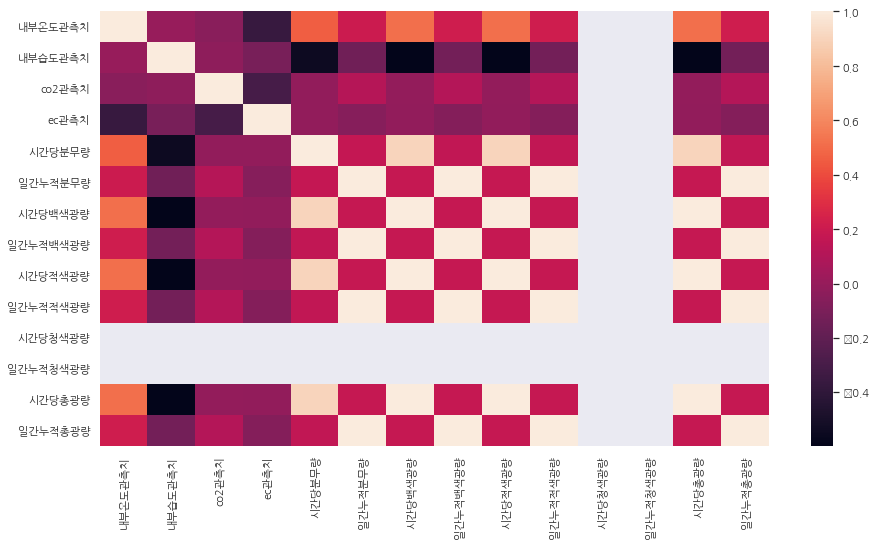

In [15]:
sns.set(font="NanumGothic",rc = {'figure.figsize':(15,8)})

sns.heatmap(train_X_case["01"].drop((["DAT", "obs_time"]), axis=1).corr())

상관관계에서 뭔가를 얻지는 못했다. 

상관관계 표에 아예 색칠되지 않은 부분은 통제변인으로써 작용하는 듯 하다.

### null 값 처리

null 값이 없다.

In [16]:
for i in range(1, 29):
    CASE = str(i).zfill(2)
    for _ in train_X_case[CASE].isnull().sum():
        if _ == True:
            print(_)

### 노이즈값 처리

- 시간당 내부 평균온도: 4도~40도
- 시간당 내부 평균습도: 0% ~ 100%
- 시간당 내부 평균 co2 농도 : 0ppm ~ 1200 ppm
- 시간당 평균 EC : 0 ~ 8
- 시간당 분무량 : 0 ~ 3000 / 일간 누적 분무량 0 ~ 72,000
- 시간당 백색광량 : 0 ~ 120,000 / 일간 누적 백색광량 0 ~ 2,880,000
- 시간당 적색광량 : 0 ~ 120,000 / 일간 누적 적색광량 0 ~ 2,880,000 
- 시간당 청색광량 : 0 ~ 120,000 / 일간 누적 청색광량 0 ~ 2,880,000
- 시간당 총광량 : 0 ~ 120,000 / 일간 누적 총광량 0 ~ 2,880,000




In [17]:
col = train_X_case["01"].columns
col

Index(['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

In [18]:
control_variable = pd.DataFrame()

noise = [[]]

for i in range(1, 29):
    noise.append([])
    CASE = str(i).zfill(2)

    # 내부 온도 관측치 
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[2]]<4].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[2]]>40].index)   

    # 내부습도 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[3]]<=0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[3]]>100].index)   

    # co2 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[4]]<=0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[4]]>1200].index)   

    # ec 관측치
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[5]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[5]]>8].index)   

    # 시간당 분무량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[6]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[6]]>3000].index)   

    # 누적 분무량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[7]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[7]]>72000].index)   

    # 시간당 백색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[8]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[8]]>120000].index)   

    # 일간 누적 백색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[9]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[9]]> 2880000].index)   

    # 시간당 적색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[10]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[10]]>120000].index)   

    # 일간 누적 적색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[11]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[11]]>2880000].index)   

    # 시간당 청색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[12]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[12]]>120000].index)   

    # 일간 누적 청색광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[13]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[13]]>2880000].index)   

    # 시간당 총광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[14]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[14]]>120000].index)   

    # 일간 누적 총광량
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[15]]<0].index)    
    noise[i].append(train_X_case[CASE][train_X_case[CASE][col[15]]>2880000].index)   

    # # 중복값 제거
    # noise[i] = list(set(noise[i]))

In [19]:
for i in range(1, 29):
    for j in range(28):
        if len(noise[i][j]) != 0 and len(noise[i][j])<100:
            print("case{} {}".format(i, col[j//2+2]))
            print(noise[i][j], "\n")

case1 co2관측치
Int64Index([639, 640, 641, 642], dtype='int64') 

case3 co2관측치
Int64Index([ 12,  15,  16,  17,  18,  19,  20,  36,  39,  40,  41,  42,  43,
             44,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 159, 160,
            161, 162, 180, 181, 182, 183, 184, 185, 186, 187, 188, 204, 205,
            206, 207, 208, 209, 210, 211, 212, 229, 230, 231, 232, 233, 234,
            235, 236, 237, 252, 253, 254, 255, 256, 257, 258, 259, 260, 325,
            326, 327, 328, 329, 330, 331, 332, 333, 334, 350, 351, 352, 353,
            354, 355, 356, 395, 396, 397, 400, 401, 402, 403, 404, 662, 663,
            664, 665, 666, 667, 668],
           dtype='int64') 

case4 내부온도관측치
Int64Index([15], dtype='int64') 

case4 내부습도관측치
Int64Index([15], dtype='int64') 

case4 co2관측치
Int64Index([549], dtype='int64') 

case6 시간당백색광량
Int64Index([15], dtype='int64') 

case6 시간당적색광량
Int64Index([15], dtype='int64') 

case6 시간당청색광량
Int64Index([15], dtype='int64') 

case6 시간당총광량
Int64Index([15], d

일단 값이 틀린 칼럼과 인덱스는 찾았으니, 대입할 값은 나중에 처리해보자.

#### co2 관측치

In [20]:
# case 1 co2관측치
train_X_case["01"].loc[[637,638, 639, 640, 641, 642, 643, 644], "co2관측치"]

637     682.600000
638     997.916667
639    1225.066667
640    1220.583333
641    1217.500000
642    1264.366667
643    1077.850000
644    1043.066667
Name: co2관측치, dtype: float64

In [21]:
# case 3 co2관측치
train_X_case["03"].loc[[ 12,  15,  16,  17,  18,  19,  20,  36,  39,  40,  41,  42,  43,
             44,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 159, 160,
            161, 162, 180, 181, 182, 183, 184, 185, 186, 187, 188, 204, 205,
            206, 207, 208, 209, 210, 211, 212, 229, 230, 231, 232, 233, 234,
            235, 236, 237, 252, 253, 254, 255, 256, 257, 258, 259, 260, 325,
            326, 327, 328, 329, 330, 331, 332, 333, 334, 350, 351, 352, 353,
            354, 355, 356, 395, 396, 397, 400, 401, 402, 403, 404, 662, 663,
            664, 665, 666, 667, 668], "co2관측치"]

12     1219.633333
15     1260.616667
16     1261.050000
17     1253.816667
18     1343.500000
          ...     
664    1252.683333
665    1263.350000
666    1358.550000
667    1360.933333
668    1232.433333
Name: co2관측치, Length: 96, dtype: float64

In [22]:
# 케이스4 co2 관측치
train_X_case["04"].loc[[548, 549, 550], "co2관측치"]

548    1034.866667
549    1311.500000
550     953.683333
Name: co2관측치, dtype: float64

In [23]:
# case 27 co2 관측치
train_X_case["27"].loc[[548,549,550], "co2관측치"]

548    1074.100000
549    1355.116667
550    1058.033333
Name: co2관측치, dtype: float64

**이 정도 co2관측량 오차는 수용될 수 있는 부분인 것 같다. 허용범위 내에 값이 아니더라도 물리적으로 가능한 값이기 때문에 그냥 넣겠다.**

#### 내부온도관측치

In [24]:
# case 4
train_X_case["04"].loc[[14,15,16], "내부온도관측치"]

14     6.921053
15     0.000000
16    16.516215
Name: 내부온도관측치, dtype: float64

온도가 0도 인것은 말이 안되므로, 앞과 뒤 온도의 평균을 넣어주겠다.

In [25]:
train_X_case["04"].loc[[15], "내부온도관측치"] = (6.921053+16.516215)/2

In [26]:
# case 8
train_X_case["08"].loc[[134,135,136,137], "내부온도관측치"]

134    39.278333
135    40.033333
136    40.363333
137    38.435000
Name: 내부온도관측치, dtype: float64

추세를 봤을 때, 큰 오차는 아니므로 그냥 유지하겠다.

In [27]:
# case 26
train_X_case["26"].loc[[51, 52, 53, 54, 55, 56, 368, 408, 409, 410, 411], "내부온도관측치"]

51     39.935001
52     40.713333
53     40.293333
54     40.428333
55     41.216666
56     42.643334
368    40.611667
408    40.143333
409    40.109999
410    40.415001
411    40.101667
Name: 내부온도관측치, dtype: float64

추세를 봤을 때, 큰 오차는 아니므로 그냥 유지하겠다.

#### ec관측치

In [28]:
# case1
train_X_case["01"].loc[[64,643,644,645, 646, 647, 648, 649, 650, 651, 652, 653, 655, 656, 657, 658, 659,
            660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671], "ec관측치"]

64     1.398022
643    0.039426
644    0.012940
645    0.018853
646    0.000000
647    0.000000
648    0.000000
649    0.000000
650    0.000000
651    0.000000
652    0.000000
653    0.000000
655    0.000000
656    0.000000
657    0.000000
658    0.000000
659    0.000000
660    0.000000
661    0.000000
662    0.000000
663    0.000000
664    0.000000
665    0.000000
666    0.000000
667    0.000000
668    0.000000
669    0.000000
670    0.000000
671    0.000000
Name: ec관측치, dtype: float64

실험의 마지막 즈음에 추세를 고려해서 ec관측치가 낮게 나타날 수는 있을 것 같다.

In [29]:
# case 3
train_X_case["05"].loc[[39,  40,  41,  42,  43,  44,  45, 245, 246, 247, 271, 272, 273,
            302, 303, 321, 322, 337, 338, 339, 340, 353, 354, 355, 356, 367,
            368, 369, 370, 377, 378, 379, 396, 397, 405, 406, 407, 408, 409,
            425, 426, 427, 428, 429, 440, 452, 453, 454, 455, 456, 457, 466,
            467, 473, 474, 475, 483, 484, 485, 486, 487, 488, 581], "ec관측치"]

39     0.0
40     0.0
41     0.0
42     0.0
43     0.0
      ... 
485    0.0
486    0.0
487    0.0
488    0.0
581    0.0
Name: ec관측치, Length: 63, dtype: float64

ec관측치가 0인 것이 의심스러워서 따로 살펴봤으나, 의도된 것인 것 같다. 나머지는 살펴보지 않아도 될 듯하다.

#### 광량

In [30]:
train_X_case["06"].loc[[14, 15, 16], ["시간당백색광량", "시간당적색광량", "시간당청색광량", "시간당총광량"]]

,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량
14,18255.1900,1659.7644,3419.6695,23334.6239
15,-138371.2461,-8793.6072,-18570.8575,-165735.7108
16,17744.6635,2128.0728,3223.8570,23096.5933


15번째 인덱스의 음수컬럼은 말이 안되기 때문에 이전과 이후의 평균값을 넣어주겠다.

In [31]:
insert_value = (np.array([18255.1900,1659.7644,3419.6695,23334.6239]) + np.array([17744.6635,2128.0728,3223.8570,23096.5933]))/2

In [32]:
train_X_case["06"].loc[[15], ["시간당백색광량", "시간당적색광량", "시간당청색광량", "시간당총광량"]] = insert_value

#### 시간당 분무량

In [33]:
# case 13
train_X_case["13"].loc[[523,524,525,600,601,602,648,649,650], "시간당분무량"]

523    1171.49
524    3144.13
525     769.00
600     537.52
601    -537.52
602    1415.83
648     653.26
649    -653.26
650    1415.83
Name: 시간당분무량, dtype: float64

시간당  분무량도 어느정도 선형적인 값이므로, 이전과 이후의 평균을 넣어주겠다.

In [34]:
train_X_case["13"].loc[[524], "시간당분무량"] = (1171.49+769)/2
train_X_case["13"].loc[[601], "시간당분무량"] = (537.52+1415.83)/2
train_X_case["13"].loc[[649], "시간당분무량"] = (635.26+1415.83)/2

#### 내부습도관측치

In [35]:
# case4
train_X_case["04"].loc[[14,15,16], "내부습도관측치"]

14     9.639473
15     0.000000
16    32.157695
Name: 내부습도관측치, dtype: float64

이렇게 갑자기 0이되는건 이상하다 생각되기 때문에 이전과 이후의 평균을 채워주겠다.

In [36]:
train_X_case["04"].loc[[14,15,16], "내부습도관측치"] = (9.639473+32.157695)/2

### 다시 데이터셋을 합치고 나누기
noise데이터를 처리했기 때문에 다시 데이터셋을 생성해준다.

### 다시 데이터셋 합치기 all_X(DataFrame)
모든데이터를 합친다.

In [37]:
all_X = pd.DataFrame()

for i in range(1,29):
    CASE = str(i).zfill(2)
    all_X = all_X.append(train_X_case[CASE])

In [38]:
all_X.shape

(18816, 16)

### 다시 데이터셋 나누기 train_X_case_day(list)

각 상추의 28일치 데이터를 분리해서 저장한다.

In [39]:
# train_X_case_day[x][y] 를 입력하면 x 케이스의 y번째 날 데이터 프레임을 리턴함
train_X_case_day = [[]]

for i in range(1,29):
    train_X_case_day.append([])
    for j in range(1,29):
        train_X_case_day[i].append(train_X_case["{}".format(str(i).zfill(2))].iloc[24*(j-1):j*24, :])

### 이상치 처리
all_x.describe() 를 통해서 이상치의 값을 어떻게 처리할지 생각해본다.

In [40]:
all_X.describe()

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,13.500000,26.028341,63.936201,498.860695,1.507566,523.682080,6365.916673,6323.873473,72910.240149,1572.430914,18201.358998,1243.069492,14139.184959,9139.373879,105250.784106
std,8.077962,3.945806,11.652230,120.421248,1.042010,543.897317,6903.680044,8120.283264,86040.447105,2936.281308,34386.384982,2470.253289,27743.227265,9087.008979,97397.224913
min,0.000000,6.921053,15.348148,60.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.750000,23.971250,57.494583,420.245833,0.929581,0.000000,1234.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7280.962850
50%,13.500000,26.291667,62.118333,473.983333,1.308517,252.000000,3360.485000,0.000000,23205.750000,0.000000,0.000000,0.000000,0.000000,9242.350000,92172.360000
75%,20.250000,28.106667,73.157166,551.105952,2.291322,769.000000,9990.570000,18236.625400,145422.700000,1495.939200,17529.296400,1306.461000,18484.700000,18255.190000,177491.499450
max,27.000000,42.643334,93.350002,1714.850000,5.462324,2951.230000,42855.230000,18564.600000,292014.969800,9928.800000,200561.760000,9399.000000,190016.450000,37892.400000,559488.881000


이게 범위가 있는 데이터 셋이여서 이상치라고 할만한게 없다. <br>
모든 데이터셋을 선형적으로 관찰하면서 발견할 수는 있겠으나, 내가 그렇게 하지는 않았기 때문에 없다고 생각하겠다.

test_train 데이터는 내가 노이즈값 처리를 하면서 얻은 지식을 전처리를 할 예정이다. 

- 광량이 음수인경우 
- 온도가 0인 경우
- 시간당 분무량이 음수인 경우
- 내부 습도가 0인 경우

에는 전 값을 채워넣거나, all_X의 평균을 채워넣으면 될 듯 하다.

# 모델링

1. lstm을 사용하는 모델
2. lgbm regressor를 사용하는 모델
3. CNN을 사용하는 모델..?? <br>(갑자기 든 생각인데, 1d CNN을 사용하거나 세로가 낮은 CNN을 사용해도 적절한 모델을 만들 수 있지 않을까 라는 생각이 든다.)

## LSTM 사용 모델

### 모듈 임포트

## LGBM regressor 사용 모델

### 모듈 임포트

## CNN 사용모델

### 모듈 임포트